# KOSPI 지수 예측

증시 자금 동향에 따른 적정 kospi 예측

## 증시 자금 동향

https://finance.naver.com/sise/sise_deposit.nhn

In [1]:
import yfinance as yf
import FinanceDataReader as fdr
import pandas_datareader as data_reader
import pickle
import pandas as pd
import korean
import matplotlib.pyplot as plt
import numpy as np
import datetime
import csv 
import sys
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
# 고객예탁금 데이터 읽기
df_cust = pd.read_csv("고객예탁금.csv")
df_cust.dropna(inplace=True)
df_cust = df_cust[['날짜', '고객예탁금', '신용잔고']]

# 날짜를 datetime 형식으로 변환
df_cust['날짜'] = pd.to_datetime(df_cust['날짜'], format='%y.%m.%d')

# 문자열을 정수로 변환
df_cust['고객예탁금'] = df_cust['고객예탁금'].str.replace(',', '').astype(int)
df_cust['신용잔고'] = df_cust['신용잔고'].str.replace(',', '').astype(int)

# 날짜 기준으로 정렬 및 인덱스 설정
df_cust = df_cust.sort_values(by='날짜')
df_cust.set_index('날짜', inplace=True)

# 결과 확인
df_cust.head(2)

,고객예탁금,신용잔고
날짜,,
2016-07-15,232662,71989
2016-07-18,229306,72342


In [3]:
df_cust.tail(2)

,고객예탁금,신용잔고
날짜,,
2024-09-12,511531,169128
2024-09-13,514007,169219


In [4]:
start_date = df_cust.index[0]
end_date = df_cust.index[-1]

df_ex = data_reader.DataReader('DEXKOUS', 'fred', start_date, end_date)

merged_df = df_cust.merge(df_ex, left_index=True, right_index=True, how='left')
merged_df['환율반영예탁금'] = merged_df['고객예탁금'] / merged_df['DEXKOUS']
merged_df['환율반영신용잔고'] = merged_df['신용잔고'] / merged_df['DEXKOUS']
merged_df.tail()

,고객예탁금,신용잔고,DEXKOUS,환율반영예탁금,환율반영신용잔고
날짜,,,,,
2024-09-09,512598,172288,1342.16,381.920188,128.366216
2024-09-10,514943,169835,1343.41,383.310382,126.420825
2024-09-11,519933,168960,1340.59,387.838937,126.034060
2024-09-12,511531,169128,1341.35,381.355351,126.087897
2024-09-13,514007,169219,1329.26,386.686577,127.303161


In [5]:
kospi = yf.download('^KS11', start=start_date, end=end_date, progress=False)
kospi.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-10,2542.689941,2544.830078,2522.479980,2523.429932,2523.429932,347700
2024-09-11,2524.860107,2526.129883,2493.370117,2513.370117,2513.370117,302600
2024-09-12,2547.500000,2572.090088,2537.870117,2572.090088,2572.090088,340500


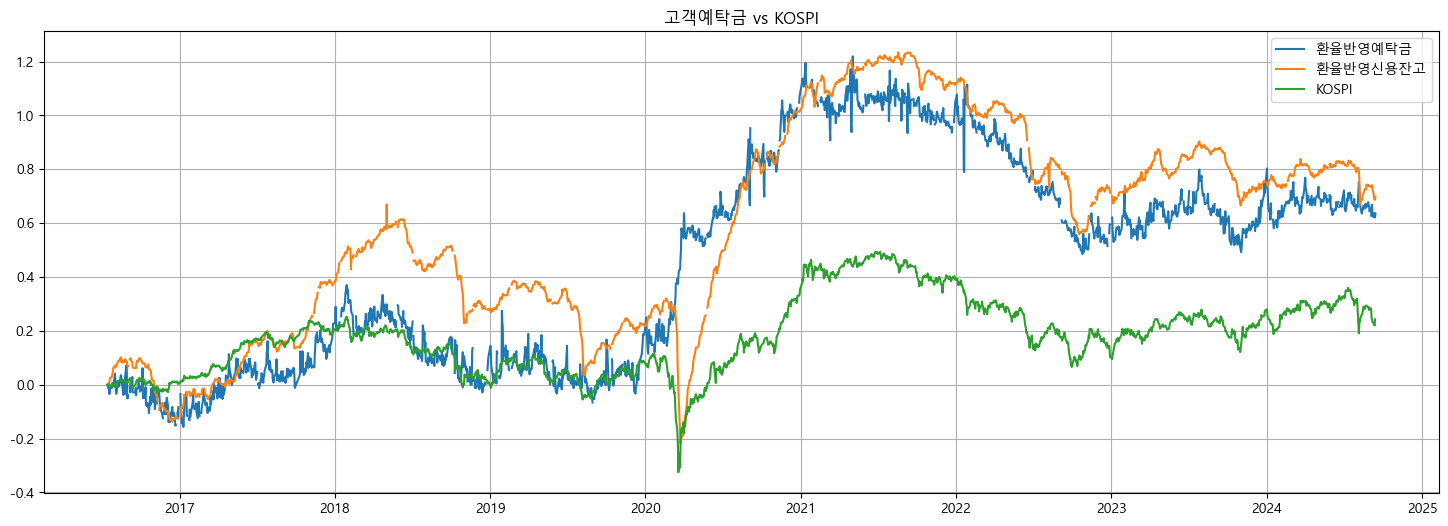

In [6]:
plt.figure(figsize=(18, 6))
plt.plot(merged_df.index, np.log(merged_df['환율반영예탁금']/merged_df['환율반영예탁금'].iloc[0]), label='환율반영예탁금')
plt.plot(merged_df.index, np.log(merged_df['환율반영신용잔고']/merged_df['환율반영신용잔고'].iloc[0]), label='환율반영신용잔고')
plt.plot(kospi.index, np.log(kospi['Close']/kospi['Close'].iloc[0]), label='KOSPI')
plt.title('고객예탁금 vs KOSPI')
plt.legend()
plt.grid()
plt.show()

In [7]:
tmp1 = merged_df.join(kospi, how='left')
tmp1.dropna(inplace=True)
tmp1.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
tmp1.corr()

,고객예탁금,신용잔고,DEXKOUS,환율반영예탁금,환율반영신용잔고,Close
고객예탁금,1.000000,0.948286,0.431785,0.978137,0.926157,0.786956
신용잔고,0.948286,1.000000,0.427077,0.920497,0.976492,0.857501
DEXKOUS,0.431785,0.427077,1.000000,0.237759,0.225514,0.071074
환율반영예탁금,0.978137,0.920497,0.237759,1.000000,0.943424,0.826848
환율반영신용잔고,0.926157,0.976492,0.225514,0.943424,1.000000,0.904884
Close,0.786956,0.857501,0.071074,0.826848,0.904884,1.000000


In [8]:
X_credit = tmp1.loc['2020-06':, ['환율반영신용잔고']].values
y_credit = tmp1.loc['2020-06':, 'Close'].values
X_credit.shape, y_credit.shape

((1018, 1), (1018,))

환율 반영 신용 잔고를 이용한 KOSPI 예측

In [9]:
lr_credit = LinearRegression()
lr_credit.fit(X_credit, y_credit)

y_pred_credit = lr_credit.predict(X_credit)

In [10]:
# 고객예탁금 최대값과 최소값 계산
max_cust_deposit = merged_df['고객예탁금'].max()
min_cust_deposit = merged_df['고객예탁금'].min()

# 최대값과 최소값이 발생한 날짜 찾기
max_cust_date = merged_df['고객예탁금'].idxmax()
min_cust_date = merged_df['고객예탁금'].idxmin()

# 억원 단위로 변환
max_cust_deposit_won = max_cust_deposit / 1e4
min_cust_deposit_won = min_cust_deposit / 1e4

# KOSPI 주가 데이터 가져오기
# merged_df와 KOSPI 데이터프레임이 날짜를 기준으로 인덱스가 설정되어 있어야 합니다.
max_cust_kospi = kospi.loc[max_cust_date]['Close']
min_cust_kospi = kospi.loc[min_cust_date]['Close']

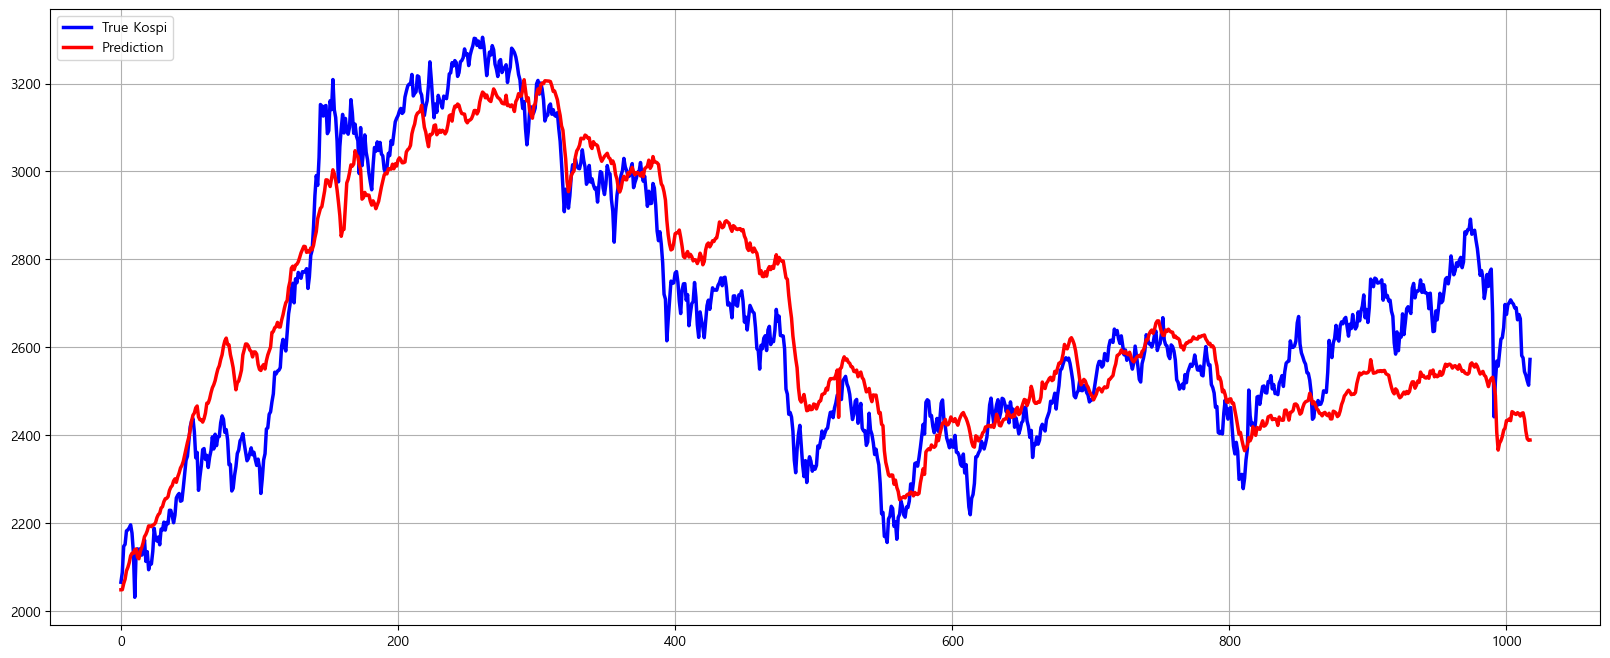

환율반영 신용 금액 기준 금일 예상 적정 KOSPI = 2453


In [11]:
# 첫 번째 그래프: 예측값과 실제값
plt.figure(figsize=(20, 8))

# True KOSPI: 굵은 파란색 선
plt.plot(np.arange(len(y_credit)), y_credit, label='True Kospi', color='blue', linewidth=2.5)

# Prediction: 굵은 빨간색 선
plt.plot(np.arange(len(y_pred_credit)), y_pred_credit, label='Prediction', color='red', linewidth=2.5)

# 기타 그래프 설정
plt.legend(loc=2)
plt.grid()
plt.show()

today_fx = 1341.8      # 환율
today_credit = 178910  #신용잔고

tc = today_credit / today_fx

prediction_credit = lr_credit.predict([[tc]])
print("환율반영 신용 금액 기준 금일 예상 적정 KOSPI = {:.0f}".format(prediction_credit[0]))

In [12]:
today_credit = 170410
today_fx = 1335.8

tc = today_credit / today_fx

print("신용잔고 : {:,} 억원".format(today_credit))
print("환율 : {:,}".format(today_fx))
print()
print("환율 반영 신용 잔고 예상 적정 KOSPI = {:,.0f}".format(prediction_credit[0]))

신용잔고 : 170,410 억원
환율 : 1,335.8

환율 반영 신용 잔고 예상 적정 KOSPI = 2,453


In [13]:
print(f"최대 고객예탁금: {max_cust_deposit_won:,.2f} 조원 (발생 날짜: {max_cust_date.strftime('%Y-%m-%d')}, KOSPI 주가: {max_cust_kospi:.2f})")
print(f"최소 고객예탁금: {min_cust_deposit_won:,.2f} 조원 (발생 날짜: {min_cust_date.strftime('%Y-%m-%d')}, KOSPI 주가: {min_cust_kospi:.2f})")

최대 고객예탁금: 77.90 조원 (발생 날짜: 2021-05-03, KOSPI 주가: 3127.20)
최소 고객예탁금: 20.82 조원 (발생 날짜: 2017-02-13, KOSPI 주가: 2078.65)
